In [1]:
import pandas as pd
import wrangle as w
import explore as e
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split

from functools import reduce

import matplotlib.pyplot as plt

# importing necessary libraries
import pandas as pd
import numpy as np


from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
%matplotlib inline

## Recreate model data from model.ipynb notebook

In [2]:
# acquire dataframe
df = w.get_perpetrator_df()

# create production dataframe based on the target variables
production_df = df[df['gname'].str.contains('Unknown')==True]

# create target variable dataframe
df1 = df[df['gname'].str.contains('Unknown')==False]

# drop columns from the dataframe that arent relevant in the predictor
model_df = df1.drop(columns=['event_id',
             'month',
             'day',
             'region',
             'latitude',
             'longitude',
             'success',
             'attacktype_n',
             'targtype_n',
             'targsubtype_n',
             'targsubtype',
             'corp1',
             'target_description',
             'nationality',
             'claimed',
             'weapdesc',
             'nkillus',
             'nkillter',
             'nwound',
             'nwoundus',
             'nwoundte',
             'property'])


production_df2 = production_df.drop(columns=['event_id',
             'region',
             'success',
             'attacktype_n',
             'targtype_n',
             'targsubtype_n',
             'targsubtype',
             'corp1',
             'target_description',
             'nationality',
             'claimed',
             'weapdesc',
             'nkillus',
             'nkillter',
             'nwound',
             'nwoundus',
             'nwoundte',
             'property'])


production_df = production_df.drop(columns=['event_id',
             'month',
             'day',
             'region',
             'latitude',
             'longitude',
             'success',
             'attacktype_n',
             'targtype_n',
             'targsubtype_n',
             'targsubtype',
             'corp1',
             'target_description',
             'nationality',
             'claimed',
             'weapdesc',
             'nkillus',
             'nkillter',
             'nwound',
             'nwoundus',
             'nwoundte',
             'property'])

# change year to object type
model_df.year = model_df.year.astype('str')
production_df.year = production_df.year.astype('str')

data = model_df


### Check differences in DFs

#### Provstate from prod_df to data

In [30]:
y = set(production_df['provstate'])
x = set(data['provstate'])

prov_diff = y.difference(x)
prov_diff = list(prov_diff)
len(prov_diff)

0

#### Data to prod_df

In [31]:
y = set(production_df['provstate'])
x = set(data['provstate'])

prov_diff2 = x.difference(y)
prov_diff2 = list(prov_diff2)
len(prov_diff2)

0

#### City from prod_df to data

In [32]:
y = set(production_df['city'])
x = set(data['city'])

city_diff = y.difference(x)
city_diff = list(city_diff)
len(city_diff)

0

#### city from data to prod

In [33]:
y = set(production_df['city'])
x = set(data['city'])

city_diff2 = x.difference(y)
city_diff2 = list(city_diff2)
len(city_diff2)

3

---

In [34]:
for i in city_diff:
    production_df = production_df[production_df.city!=i]

production_df.shape

(22259, 10)

In [35]:
for x in prov_diff:
    production_df = production_df[production_df.provstate!=x]

production_df.shape

(22259, 10)

In [36]:
for i in city_diff2:
    data = data[data.city!=i]

data.shape

(10279, 10)

In [37]:
for x in prov_diff2:
    data = data[data.provstate!=x]
    
data.shape

(10279, 10)

---

### Sanity

In [38]:
y = set(production_df['city'])
x = set(data['city'])

city_diff = y.difference(x)
city_diff = list(city_diff)
len(city_diff)

0

In [39]:
y = set(production_df['city'])
x = set(data['city'])

city_diff2 = x.difference(y)
city_diff2 = list(city_diff2)
len(city_diff2)

0

In [40]:
y = set(production_df['provstate'])
x = set(data['provstate'])

prov_diff = y.difference(x)
prov_diff = list(prov_diff)
len(prov_diff)

0

In [41]:
y = set(production_df['provstate'])
x = set(data['provstate'])

prov_diff2 = x.difference(y)
prov_diff2 = list(prov_diff2)
len(prov_diff2)

0

---

- We compare prod2 to the complete dataframe, to match the same rows that it did in the previous production dataframe

## City for pdf2

In [45]:
y = set(production_df2['city'])
x = set(production_df['city'])

city_diff3 = y.difference(x)
city_diff3 = list(city_diff3)
len(city_diff3)

0

In [46]:
production_df2.shape

(22374, 14)

In [47]:
for i in city_diff3:
    production_df2 = production_df2[production_df2.city!=i]

production_df2.shape

(22374, 14)

## Provstate for pdf2

In [51]:
y = set(production_df2['provstate'])
x = set(production_df['provstate'])

prov_diff3 = y.difference(x)
prov_diff3 = list(prov_diff3)
len(prov_diff3)

0

In [52]:
production_df2.shape

(22259, 14)

In [53]:
for i in prov_diff3:
    production_df2 = production_df2[production_df2.provstate!=i]

production_df2.shape

(22259, 14)

### Scaling

In [54]:
# create a dataframe for the gname target variable
gnames = pd.DataFrame(data.gname)

# create nkill df
nkills = pd.DataFrame(data.nkill)

# scale nkill
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(nkills)
nkills = pd.DataFrame(scaler.transform(nkills))
nkills = nkills.rename(columns={0:'nkill'})

In [55]:
data.shape[0], gnames.shape[0], nkills.shape[0]

(10279, 10279, 10279)

### Dummy df

In [56]:
# encode variables
dummy_df = pd.get_dummies(data[['country',
                                    'provstate',
                                    'city',
                                    'suicide',
                                    'attack_type', 
                                    'targtype',  
                                    'weaptype',
                                    'year']], dummy_na=False, drop_first=[True, True])

In [57]:
dummy_df = dummy_df.reset_index(drop=True)
dummy_df.index

RangeIndex(start=0, stop=10279, step=1)

In [58]:
gnames = gnames.reset_index(drop=True)
gnames.index

RangeIndex(start=0, stop=10279, step=1)

In [59]:
# add target to dataframe
dummy_df = pd.concat([dummy_df, gnames, nkills], axis=1)

In [60]:
dummy_df.shape

(10279, 1276)

---

### Gotta Create Lists Now... (or not)

In [61]:
# production_df['year'].nunique(), data['year'].nunique()

# production_df['city'].nunique(), data['city'].nunique()

# production_df['targtype'].nunique(), data['targtype'].nunique()

# prod = production_df['country'].unique()
# prod = prod.tolist()

# data_list =data.country.unique()
# data_list = data_list.tolist()

# data_list2 = data.provstate.unique()
# data_list2 =data_list2.tolist()

# prod2 = production_df['provstate'].unique()
# prod2 = prod2.tolist()

# prod3 = production_df['city'].unique()
# prod3 = prod3.tolist()

# data_list3 =data.city.unique()
# data_list3 = data_list3.tolist()

# # match lists function: 
# def non_match_elements(list_a, list_b):
#     non_match = []
#     for i in list_a:
#         if i not in list_b:
#             non_match.append(i)
#     return non_match

# non_match = non_match_elements(prod, data_list)
# print('Non matched countries: ', non_match)

# non_match2 = non_match_elements(prod2, data_list2)
# print('Non matched provstates: ', non_match2)

# non_match3 = non_match_elements(prod3, data_list3)
# print('Non matched cities: ', non_match3)

# len(non_match3)


# non_match3 = non_match3[:775]

# non_match

# for match in non_match:
#     production_df = production_df[production_df.country!= match]

# production_df.shape, data.shape

# non_match2

# for match2 in non_match2:
#     production_df = production_df[production_df.provstate!= match2]
    

# production_df.shape, data.shape

# for match3 in non_match3:
#     production_df = production_df[production_df.city!= match3]

# production_df.shape, data.shape

### Production Data Block

In [62]:
# size difference between prod df and og model df

In [63]:
production_df.shape

(22259, 10)

In [64]:
# create a dataframe for the gname target variable
gnames2 = pd.DataFrame(production_df.gname)

# create nkill df
nkills2 = pd.DataFrame(production_df.nkill)

scaler2 = MinMaxScaler()

scaler2.fit(nkills2)
nkills2 = nkills2.rename(columns={0:'nkill'})

In [65]:
# encode variables
dummy_df2 = pd.get_dummies(production_df[['country',
                                    'provstate',
                                    'city',
                                    'suicide',
                                    'attack_type', 
                                    'targtype',  
                                    'weaptype',
                                    'year']], dummy_na=False, drop_first=[True, True])

In [66]:
gnames2 = gnames2.reset_index(drop=True)
gnames2.index

RangeIndex(start=0, stop=22259, step=1)

In [67]:
dummy_df2 = dummy_df2.reset_index(drop=True)
dummy_df2.index

RangeIndex(start=0, stop=22259, step=1)

In [68]:
nkills2 = nkills2.reset_index(drop=True)
nkills2.index

RangeIndex(start=0, stop=22259, step=1)

In [69]:
gnames2.shape, nkills2.shape, dummy_df2.shape

((22259, 1), (22259, 1), (22259, 1274))

In [70]:
# add target to dataframe
dummy_df2 = pd.concat([dummy_df2, gnames2, nkills2], axis=1)

#### Prod DF Size

In [71]:
#X_train2= train2.drop(columns=['gname'])
#y_train2 = train2.gname

#X_validate2 = validate2.drop(columns=['gname'])
#y_validate2 = validate2.gname

X_test2 = dummy_df2.drop(columns=['gname'])
y_test2 = dummy_df2.gname

In [72]:
X_test2.shape, y_test2.shape

((22259, 1275), (22259,))

#### OG DF Size

In [73]:
def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.27, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.35, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

In [74]:
# split into train, validate, test
train, validate, test = train_validate_test_split(dummy_df, target='gname', seed=123)

# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train= train.drop(columns=['gname'])
y_train = train.gname

X_validate = validate.drop(columns=['gname'])
y_validate = validate.gname

X_test = test.drop(columns=['gname'])
y_test = test.gname

In [75]:
X_train.shape, X_validate.shape, X_test.shape

((4876, 1275), (2627, 1275), (2776, 1275))

---

### Create Model

In [76]:
# for classification you can change the algorithm to gini or entropy (information gain).  
# Default is gini.

clf = DecisionTreeClassifier(max_depth=5, random_state=123)

# model.fit(X, y)

clf = clf.fit(X_train, y_train)

# make prediction on train obeservations

y_pred = clf.predict(X_train)

# y_pred_proba = clf.predict_proba(X_train2)

# Eval model
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.94


In [77]:
metrics = []
for i in range(1, 15):
    tree = DecisionTreeClassifier(max_depth=i, random_state=17)
    tree = tree.fit(X_train, y_train)
    in_sample_accuracy = tree.score(X_train, y_train)
    
    out_of_sample_accuracy = tree.score(X_validate, y_validate)
    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
dt_df = pd.DataFrame(metrics)
dt_df["difference"] = dt_df.train_accuracy - dt_df.validate_accuracy
dt_df

,max_depth,train_accuracy,validate_accuracy,difference
0,1,0.614233,0.618576,-0.004343
1,2,0.766407,0.769699,-0.003292
2,3,0.836957,0.841644,-0.004688
3,4,0.898893,0.899886,-0.000993
4,5,0.940115,0.937571,0.002543
5,6,0.961649,0.957366,0.004283
6,7,0.968007,0.958888,0.009118
7,8,0.969647,0.959650,0.009997
8,9,0.974569,0.966121,0.008448
9,10,0.977441,0.963837,0.013603


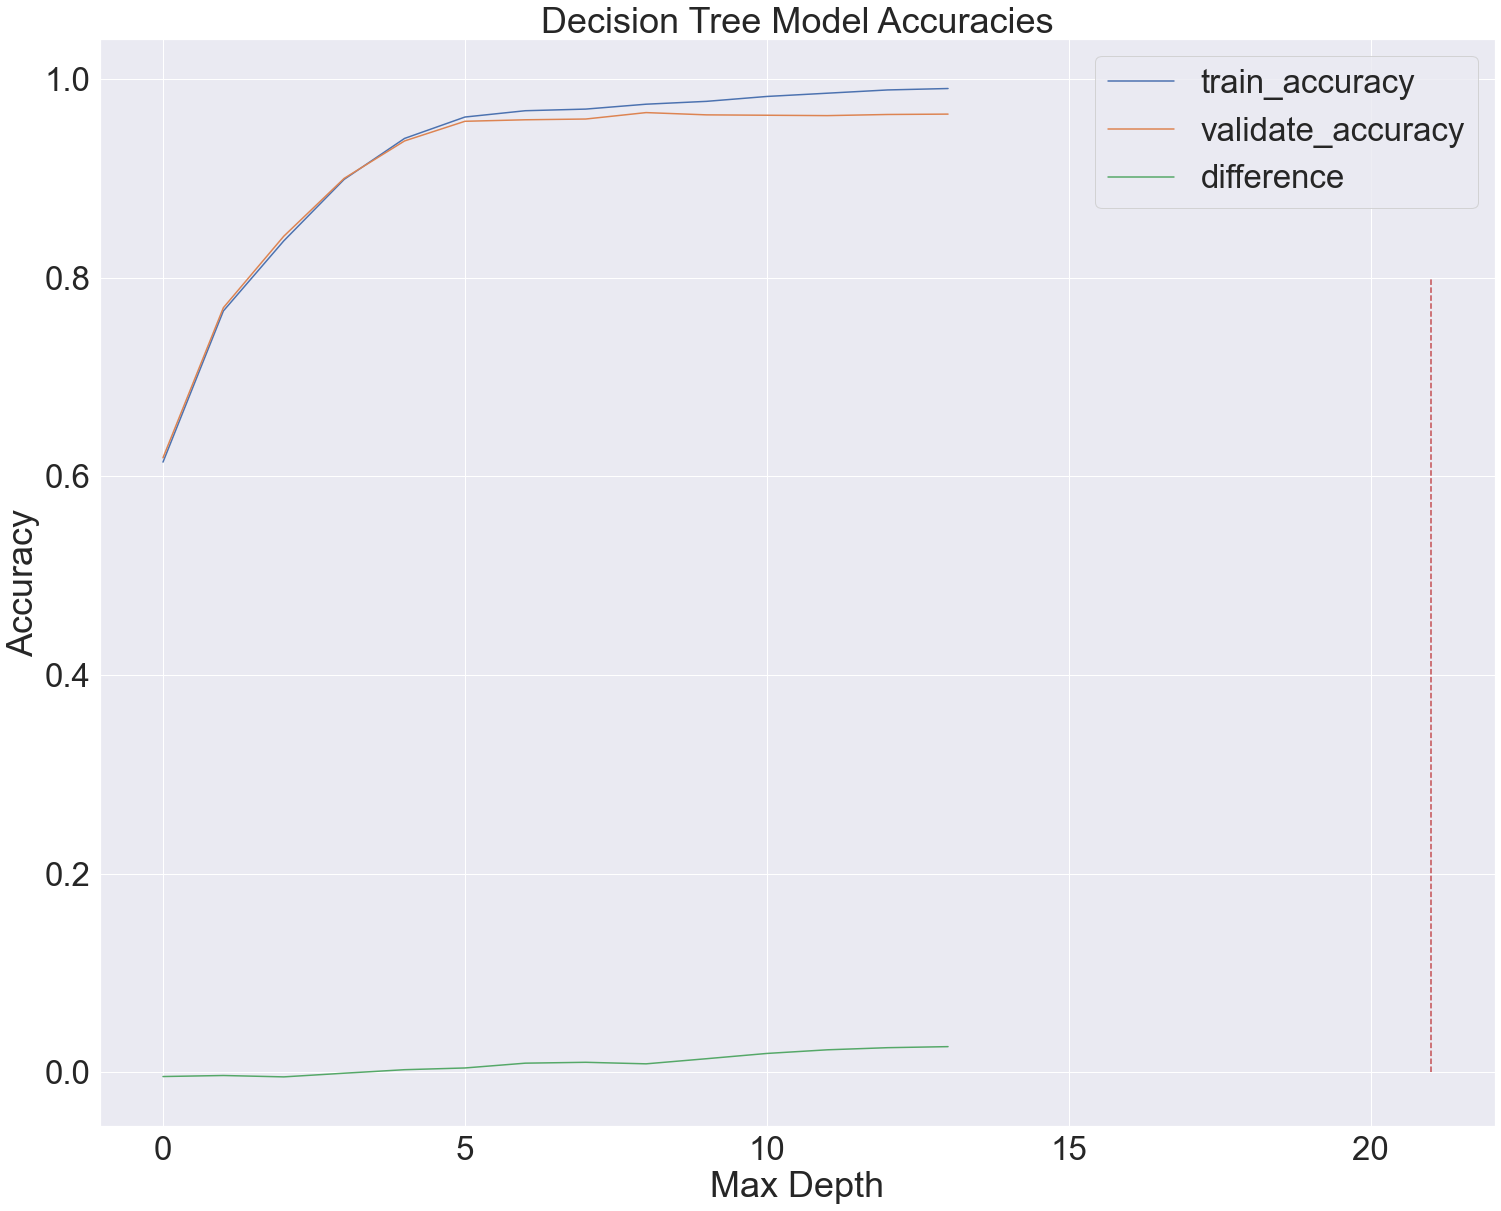

In [78]:
plt.rcParams['figure.figsize'] = [25, 20]
sns.set(font_scale = 3)
dt_df[['train_accuracy', 'validate_accuracy', 'difference' ]].plot()
plt.title("Decision Tree Model Accuracies")
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.vlines(x=[21], ymin=0, ymax=.8, colors='r', linestyles='dashed')
plt.show()

In [79]:
tree = DecisionTreeClassifier(max_depth=5, random_state=123)

tree = tree.fit(X_train, y_train)

tree.score(X_test, y_test)

0.9340778097982709

<Figure size 1800x1080 with 0 Axes>

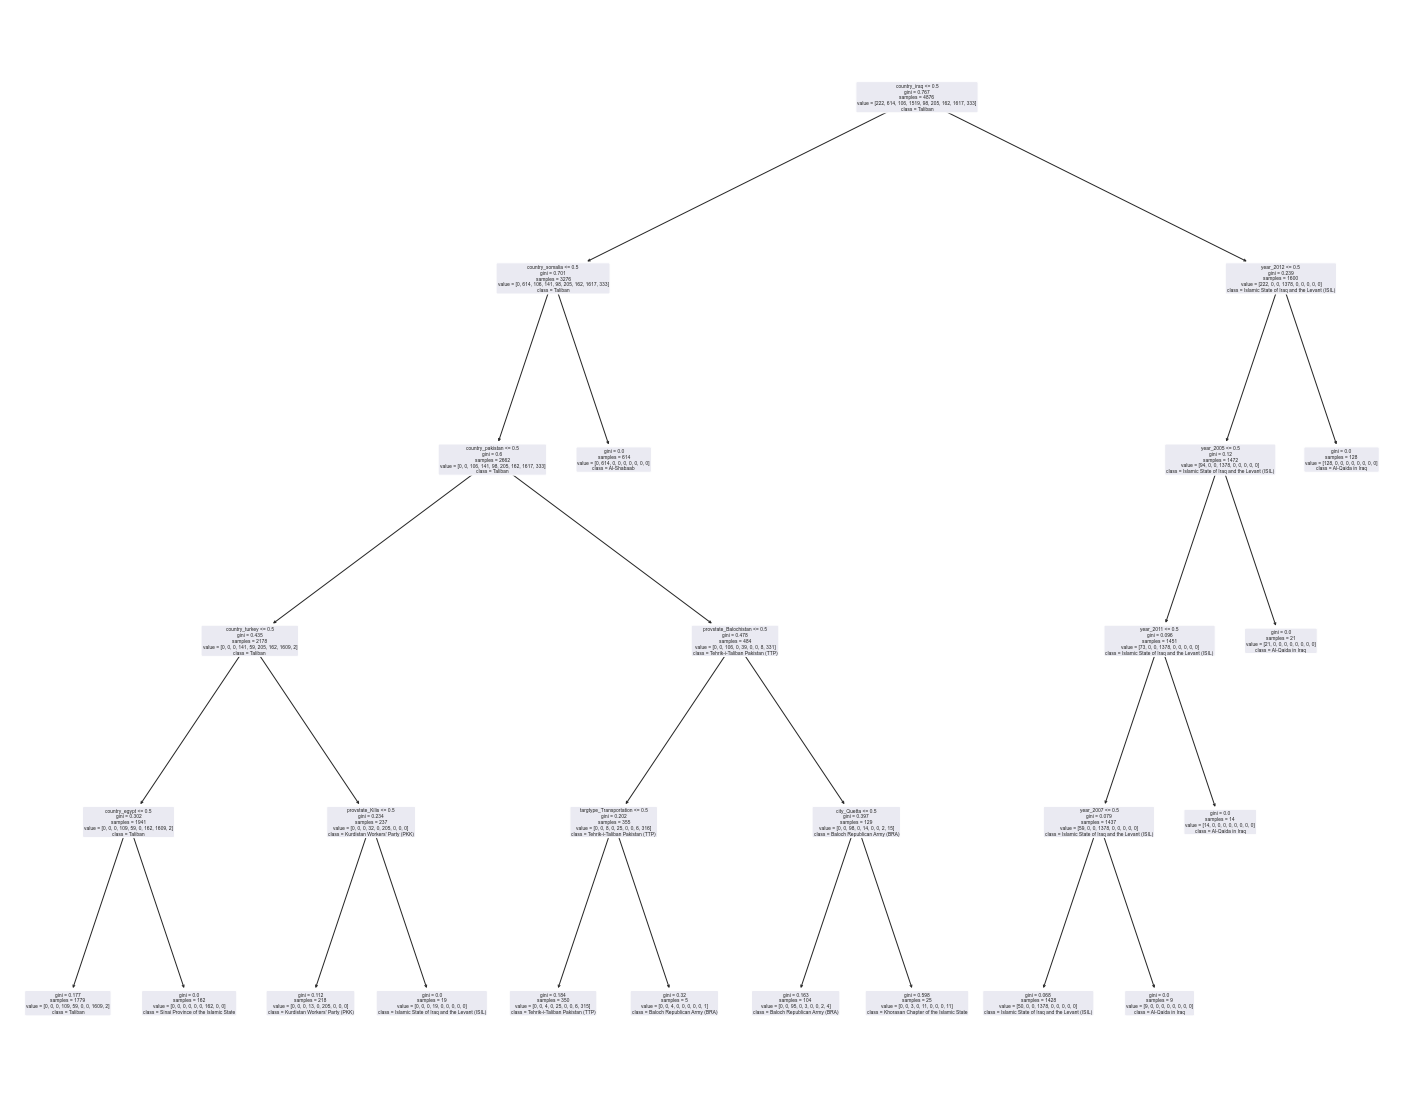

<Figure size 1800x1080 with 0 Axes>

In [80]:
plot_tree(clf, feature_names=X_train.columns, class_names=clf.classes_, rounded=True)
plt.figure(figsize=(25, 15))

### Testing on Unk DF

In [81]:
# for classification you can change the algorithm to gini or entropy (information gain).  
# Default is gini.

clf = DecisionTreeClassifier(max_depth=4, random_state=123)

# model.fit(X, y)

clf = clf.fit(X_train, y_train)

# make prediction on train obeservations

y_pred = clf.predict(X_test2)

In [82]:
unk = pd.DataFrame(y_test2)
labels = pd.DataFrame(y_pred)

In [83]:
production_df2 = production_df2.reset_index()

In [84]:
production_df2['predictions'] = labels

In [85]:
production_df2

,date,year,month,day,country,provstate,city,latitude,longitude,suicide,attack_type,targtype,gname,weaptype,nkill,predictions
0,2001-01-01,2001,1,1,turkey,Istanbul,Istanbul,41.106178,28.689863,0,Bombing/Explosion,Private Citizens & Property,Unknown,Explosives,0.0,Kurdistan Workers' Party (PKK)
1,2001-01-10,2001,1,10,turkey,Istanbul,Istanbul,41.106178,28.689863,0,Armed Assault,Police,Unknown,Firearms,1.0,Kurdistan Workers' Party (PKK)
2,2001-01-23,2001,1,23,turkey,Mersin,Unknown,36.806853,34.628893,0,Bombing/Explosion,Government (General),Unknown,Explosives,0.0,Kurdistan Workers' Party (PKK)
3,2001-01-28,2001,1,28,pakistan,Sindh,Karachi,24.891115,67.143311,0,Assassination,Religious Figures/Institutions,Unknown,Firearms,5.0,Tehrik-i-Taliban Pakistan (TTP)
4,2001-02-07,2001,2,7,pakistan,Islamabad Capital Territory,Islamabad,33.671638,73.056068,0,Bombing/Explosion,Private Citizens & Property,Unknown,Explosives,0.0,Tehrik-i-Taliban Pakistan (TTP)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22254,2017-12-30,2017,12,30,iraq,Baghdad,Baghdad,33.303566,44.371773,0,Bombing/Explosion,Business,Unknown,Explosives,0.0,Islamic State of Iraq and the Levant (ISIL)
22255,2017-12-30,2017,12,30,iraq,Kirkuk,Kirkuk,35.452110,44.375465,0,Bombing/Explosion,Business,Unknown,Explosives,0.0,Islamic State of Iraq and the Levant (ISIL)
22256,2017-12-30,2017,12,30,afghanistan,Balkh,Mazari Sharif,36.709930,67.115700,0,Bombing/Explosion,Private Citizens & Property,Unknown,Explosives,0.0,Taliban
22257,2017-12-30,2017,12,30,iraq,Kirkuk,Kirkuk,35.452110,44.375465,0,Bombing/Explosion,Business,Unknown,Explosives,0.0,Islamic State of Iraq and the Levant (ISIL)


In [ ]:
production_df2.to_csv('terrorism_predictions.csv')